Best C: {'clf__C': np.float64(0.01778279410038923)}
Holdout AUC: 0.843
XGBoost Holdout AUC: 0.799
Stacking Holdout AUC: 0.838
Class distribution: 0.286
SMOTE Holdout AUC: 0.844
               Model       AUC Improvement
0        Original LR  0.843468    Baseline
1            XGBoost  0.798761     +-0.045
2  Ensemble Stacking  0.838068     +-0.005
3         SMOTE + LR  0.843706      +0.000


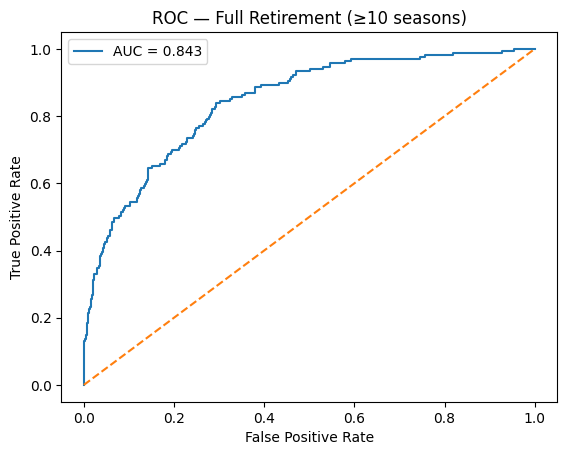

            feature      coef
0               age -0.417601
3               ppg  0.274175
4               rpg  0.265019
7               bpg  0.225331
1                 g  0.222307
15           num_tm -0.215761
5               apg  0.175342
2                mp  0.158997
10       fg_percent  0.137535
12       ft_percent  0.133864
13           ast_to  0.114303
9              pfpg  0.090947
14  ast_plus_pts_to  0.060601
19           pos_PF -0.035402
18            pos_G -0.028849
20           pos_PG  0.025830
8               tpg  0.021925
6               spg  0.020333
17            pos_F  0.016156
22           pos_SG  0.010479
            feature  importance
0               age    0.021530
15           num_tm    0.009859
5               apg    0.008600
3               ppg    0.007976
1                 g    0.007678
7               bpg    0.007271
4               rpg    0.004885
12       ft_percent    0.004352
13           ast_to    0.003831
10       fg_percent    0.003432
2                m

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

player_career = pd.read_csv("https://raw.githubusercontent.com/Cameron2003M/DS-340W-Project/main/Player%20Career%20Info.csv")
player_total = pd.read_csv("https://raw.githubusercontent.com/Cameron2003M/DS-340W-Project/main/Player%20Totals.csv")



player_career.columns = player_career.columns.str.strip()
player_total.columns = player_total.columns.str.strip()

df = player_total.merge(
    player_career[['player_id','player','num_seasons','first_seas','last_seas']],
    on="player_id",
    how="left"
)

if 'player_x' in df.columns:
    df = df.drop(columns=['player_x'])
if 'player_y' in df.columns:
    df = df.rename(columns={'player_y':'player'})

df = df[df['lg'] == 'NBA']
df = df[df['experience'] == 2]
df = df[df['last_seas'] != 2024]

count_stats = ['g','gs','mp','fg','fga','x3p','x3pa','x2p','x2pa','ft','fta','orb','drb','trb','ast','stl','blk','tov','pf','pts']

def first_nonnull(s):
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) else np.nan

agg_dict = {c: 'sum' for c in count_stats}
agg_dict.update({
    'player': first_nonnull,
    'age': first_nonnull,
    'pos': first_nonnull,
    'first_seas': first_nonnull,
    'num_seasons': first_nonnull
})

grouped = df.groupby(['player_id','season'], as_index=False).agg(agg_dict)
tm_counts = df.groupby(['player_id','season'])['tm'].nunique().reset_index().rename(columns={'tm':'num_tm'})
df2 = grouped.merge(tm_counts, on=['player_id','season'], how='left')

df2['surv10'] = (df2['num_seasons'].astype(float) >= 10).astype(int)

df2['fg_percent'] = df2['fg'] / df2['fga'].replace(0, np.nan)
df2['x3p_percent'] = df2['x3p'] / df2['x3pa'].replace(0, np.nan)
df2['ft_percent'] = df2['ft'] / df2['fta'].replace(0, np.nan)

df2['mpg'] = df2['mp'] / df2['g'].replace(0, np.nan)
df2['ppg'] = df2['pts'] / df2['g'].replace(0, np.nan)
df2['rpg'] = df2['trb'] / df2['g'].replace(0, np.nan)
df2['apg'] = df2['ast'] / df2['g'].replace(0, np.nan)
df2['spg'] = df2['stl'] / df2['g'].replace(0, np.nan)
df2['bpg'] = df2['blk'] / df2['g'].replace(0, np.nan)
df2['tpg'] = df2['tov'] / df2['g'].replace(0, np.nan)
df2['pfpg'] = df2['pf'] / df2['g'].replace(0, np.nan)

df2['ast_to'] = df2['ast'] / df2['tov'].replace(0, np.nan)
df2['ast_plus_pts_to'] = (df2['ast'] + df2['pts']) / df2['tov'].replace(0, np.nan)

ratio_cols = ['fg_percent','x3p_percent','ft_percent','mpg','ppg','rpg','apg','spg','bpg','tpg','pfpg','ast_to','ast_plus_pts_to']
df2[ratio_cols] = df2[ratio_cols].fillna(0)

df2['pos_primary'] = df2['pos'].astype(str).str.split('-').str[0]
pos_dummies = pd.get_dummies(df2['pos_primary'], prefix='pos')
df2 = pd.concat([df2, pos_dummies], axis=1)

feature_cols = ['age','g','mp','ppg','rpg','apg','spg','bpg','tpg','pfpg','fg_percent','x3p_percent','ft_percent','ast_to','ast_plus_pts_to','num_tm'] + list(pos_dummies.columns)

X = df2[feature_cols]
y = df2['surv10']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=23, stratify=y)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', solver='liblinear', max_iter=3000))
])

param_grid = {'clf__C': np.logspace(-3, 3, 25)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=23)

grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print("Best C:", grid.best_params_)
print("Holdout AUC:", round(test_auc, 3))

xgb_model = xgb.XGBClassifier(random_state=23, eval_metric='logloss')
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('xgb', xgb_model)])
xgb_pipe.fit(X_train, y_train)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
test_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("XGBoost Holdout AUC:", round(test_auc_xgb, 3))

base_learners = [
    ('lr', LogisticRegression(C=0.1, random_state=23)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=23)),
    ('xgb', xgb.XGBClassifier(random_state=23))
]
stacking_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=5))
])
stacking_pipe.fit(X_train, y_train)
y_proba_stack = stacking_pipe.predict_proba(X_test)[:, 1]
test_auc_stack = roc_auc_score(y_test, y_proba_stack)
print("Stacking Holdout AUC:", round(test_auc_stack, 3))

print(f"Class distribution: {y.mean():.3f}")
smote_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=23)),
    ('clf', LogisticRegression(penalty='l2', solver='liblinear', max_iter=3000))
])
smote_pipe.fit(X_train, y_train)
y_proba_smote = smote_pipe.predict_proba(X_test)[:, 1]
test_auc_smote = roc_auc_score(y_test, y_proba_smote)
print("SMOTE Holdout AUC:", round(test_auc_smote, 3))

comparison_data = {
    'Model': ['Original LR', 'XGBoost', 'Ensemble Stacking', 'SMOTE + LR'],
    'AUC': [test_auc, test_auc_xgb, test_auc_stack, test_auc_smote],
    'Improvement': ['Baseline', f"+{test_auc_xgb-test_auc:.3f}", f"+{test_auc_stack-test_auc:.3f}", f"+{test_auc_smote-test_auc:.3f}"]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — Full Retirement (≥10 seasons)")
plt.legend()
plt.show()

scaler = best_model.named_steps['scaler']
clf = best_model.named_steps['clf']
X_train_scaled = scaler.fit_transform(X_train)
clf.fit(X_train_scaled, y_train)

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef': clf.coef_[0]
}).sort_values(by='coef', key=lambda v: abs(v), ascending=False)
print(coef_df.head(20))

perm = permutation_importance(best_model, X_test, y_test, scoring='roc_auc', n_repeats=20, random_state=23)
imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm.importances_mean
}).sort_values(by='importance', ascending=False)
print(imp_df.head(15))

rf = RandomForestClassifier(n_estimators=500, random_state=23, class_weight='balanced_subsample')
gb = GradientBoostingClassifier(random_state=23)
benchmarks = []
for name, model in [('Random Forest', rf), ('GBM', gb)]:
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    benchmarks.append((name, scores.mean(), scores.std()))
print("\nCV AUC Benchmarks:")
for name, mean_auc, std_auc in benchmarks:
    print(f"{name}: {mean_auc:.3f} ± {std_auc:.3f}")

corr_vars = ['age', 'g', 'mp', 'ppg', 'rpg', 'apg', 'spg', 'bpg', 'tpg', 'fg_percent', 'x3p_percent']
corr_names = ['Age', 'Games', 'Minutes', 'Points', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'FG%', '3P%']
plt.figure(figsize=(12, 10))
corr_matrix = X[corr_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, square=True, fmt='.2f', xticklabels=corr_names, yticklabels=corr_names)
plt.title('Correlation Matrix of Performance Metrics')
plt.tight_layout()
plt.show()

avg_probability = y_test.mean()
features = ['age', 'g', 'fg_percent', 'mp', 'ppg', 'rpg', 'apg', 'spg', 'bpg', 'tpg']
names = ['Age', 'Games', 'FG%', 'Minutes', 'Points', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers']
for feature, name in zip(features, names):
    plt.figure(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(best_model, X_test, [feature], line_kw={'color': 'black', 'linewidth': 3})
    plt.axhline(y=avg_probability, color='green', linestyle='--', linewidth=3, label=f'Avg: {avg_probability:.3f}')
    plt.legend()
    plt.title(f'PDP: {name}')
    plt.ylabel('Fitted Probability')
    plt.xlabel(name)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
